# Code to: **Quantitative omnigenic model discovers interpretable genome-wide associations** 
## by Ruzickova, Hledik & Tkacik

Code for running and evaluating the QOM and PRS and shuffling regulatory networks to test their predictive power.

## 1. Load libraries and pre-processed data

In [1]:
import os, sys

#misc
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

exec(open('scripts/load_paths.py', 'r').read())

from copy import deepcopy
import re
from importlib import reload
from joblib import Parallel, delayed, parallel_backend
from pathlib import Path
from glob import glob

#plotting
import matplotlib.pyplot as plt

#custom functions
import functions as f
# import polyms_statistics_functions as pf

#scipy stats
from scipy import stats, optimize
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr, spearmanr

#ML
from sklearn.linear_model import MultiTaskLassoCV, Lasso

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import csv
import math

import string
alphabet = list(string.ascii_uppercase)

import warnings
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")
from sklearn.linear_model import LinearRegression

defined absolute path:  and appended sub-folders scripts and results and defined init_SEM_GWAS_path: scripts/, results_path: results/, data_path: data/


In [2]:
exec(open(init_SEM_GWAS_path+'load_data.py', 'r').read())

loading data
loaded X_df_norm, X_df_norm_full, Y_df_norm, B_prior, D_prior, test_folds_df, val_folds_df and defined QOM_bound_prior, N_folds, individuals_test, individuals_train, individuals_val, individuals_testval


## 2. Cis / QOM 0th order

### 2.1 fit cis for different values of L1 regulariser

In [3]:
def compute_D_for_one_lambda(D_prior, lambd):
    '''
    Lasso (L1 norm regularised) regression
    D_prior: (N_markers, N_genes) binary matrix defining the sparsity strustuce of the direct effects D
    lambd: L1 norm regularisation strength
    returns: 
        D: (N_markers, N_genes) matrix of direct genetic effects
    '''
    D = 0.0*D_prior
    for i, gene in enumerate(Y_df_norm.columns):
        if i%30==0: print('lambda {}, gene {}/{}'.format(lambd, i, Y_df_norm.shape[1]))
        clf = Lasso(alpha = lambd, max_iter = 20000)
        cis_SNPs_index = D_prior.loc[D_prior.loc[:, gene]>0, gene].index
        if len(cis_SNPs_index) > 0:
            clf.fit(X_df_norm.iloc[individuals_train].loc[:, cis_SNPs_index], Y_df_norm.iloc[individuals_train].loc[:, gene])
            D.loc[cis_SNPs_index, gene] = clf.coef_
    return D

In [ ]:
D_cis = {} 
lambd_list_cis = [0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01]

for lambd in lambd_list_cis:
    print('L1 lambda ', lambd) 
    # compute and save:
    D_cis[lambd] = compute_D_for_one_lambda(D_prior, lambd)
    D_cis[lambd].to_csv(results_path+'D_cis_lasso_genebygene_lambd{}.csv'.format(lambd))

# or load optimal D precomputed
# D = pd.read_csv(precomp_results_path+'D_cis_lasso_genebygene.csv', index_col = 0)

L1 lambda  0
L1 lambda  0.001
L1 lambda  0.002
L1 lambda  0.003
L1 lambda  0.004
L1 lambda  0.005
L1 lambda  0.006


In [114]:
# compute predicted gene expressions
Y_pred_cis = {}
for lambd in lambd_list_cis:
    print('L1 lambda ', lambd) 
    Y_pred_cis[lambd] = X_df_norm@D_cis[lambd]

L1 lambda  0.0
L1 lambda  0.001
L1 lambda  0.002
L1 lambda  0.003
L1 lambda  0.004
L1 lambda  0.005
L1 lambda  0.006
L1 lambda  0.007
L1 lambda  0.008
L1 lambda  0.009
L1 lambda  0.01
L1 lambda  0.011
L1 lambda  0.012
L1 lambda  0.013
L1 lambda  0.014
L1 lambda  0.015
L1 lambda  0.016
L1 lambda  0.017
L1 lambda  0.018
L1 lambda  0.019
L1 lambda  0.02
L1 lambda  0.021
L1 lambda  0.022
L1 lambda  0.023
L1 lambda  0.024
L1 lambda  0.025
L1 lambda  0.026
L1 lambda  0.027
L1 lambda  0.028
L1 lambda  0.029
L1 lambda  0.03
L1 lambda  0.031
L1 lambda  0.032
L1 lambda  0.033
L1 lambda  0.034
L1 lambda  0.035
L1 lambda  0.036
L1 lambda  0.037
L1 lambda  0.038
L1 lambda  0.039
L1 lambda  0.04
L1 lambda  0.041
L1 lambda  0.042
L1 lambda  0.043
L1 lambda  0.044
L1 lambda  0.045
L1 lambda  0.046
L1 lambda  0.047
L1 lambda  0.048
L1 lambda  0.049
L1 lambda  0.05
L1 lambda  0.055
L1 lambda  0.06
L1 lambda  0.065
L1 lambda  0.07
L1 lambda  0.075
L1 lambda  0.08
L1 lambda  0.085
L1 lambda  0.09
L1 lambd

### 2.2 pick optimal regularisation

In [162]:
def choose_optimal_L1reg(Y_pred, regularisation_identifier, h2, plot=True):
    '''
    Y_pred: dict; keys: regularisation strengths (lambda), values: model predicted expressions,
    regularisation_identifier: str; which performance matrix to use for picking optimal. 
        'R2': variance R^2 = r^2(Y_pred, Y_real) in GE explained for all genes in aggregate
        'R2_gbg': average per-gene variance explained, RY2 computed for each gene separately
        'foh2': fraction of heritability explained, per-gene R^2/h2
        'rR2h2': pearson r^2 between per-gene R^2 and heritability h2
    h2: pandas dataframe; indexed by gene name. per-gene heritability estimate
    plot: bool; if True plots validation performance r_val as a funtion of lambda
    
    returns: 
        lambd_opt: optimal regulariser valua
        R2_gbg: (N_genes, N_folds) per-gene variance explained for each test fold
        E_R2_gbg: (N_folds) per-gene variance explained, average accorss genes
        R2_R2_h2: (N_folds) pearson r^2 between per-gene R^2 and heritability h2
        foh2: (N_folds) per-gene fraction of h2 explained, average accross genes 
        R2: (N_folds) variance in GE explained for all genes in aggregate
    ''' 
    R2_gbg, E_R2_gbg, R2_R2_h2, foh2, R2 = [], [], [], [], []
    
    r_val = []
    lambdas = list(Y_pred.keys())
    for lambd in lambdas:
        print(lambd)
        r_val_temp = []
        R2_gbg_temp = []
        for i in range(N_folds):
            indiv_val_temp = val_folds_df.iloc[i].values
            if regularisation_identifier == 'R2':   # pick lambda based on R2
                r_val_temp.append(pearsonr(Y_pred[lambd].iloc[indiv_val_temp].values.flatten(), Y_df_norm.iloc[indiv_val_temp].values.flatten())[0]**2)
            elif regularisation_identifier == 'foh2':# pick lambda based on E_genes(R2/h2)
                R2_gbg_temp = []
                for gene in heritability_df.index:
                    R2_gbg_temp.append(pearsonr(Y_pred[lambd].iloc[indiv_val_temp].loc[:, gene], Y_df_norm.iloc[indiv_val_temp].loc[:, gene])[0]**2)
                R2_gbg_temp = np.nan_to_num(R2_gbg_temp, nan=0)
                r_val_temp.append(np.mean(R2_gbg_temp/heritability_df.h2))
            elif regularisation_identifier == 'rR2h2':# pick lambda based on r(R2, h2)
                R2_gbg_temp = []
                for gene in heritability_df.index:
                    R2_gbg_temp.append(pearsonr(Y_pred[lambd].iloc[indiv_val_temp].loc[:, gene], Y_df_norm.iloc[indiv_val_temp].loc[:, gene])[0]**2)
                R2_gbg_temp = np.nan_to_num(R2_gbg_temp, nan=0)
                r_val_temp.append(pearsonr(R2_gbg_temp, heritability_df.h2)[0]**2)
            elif regularisation_identifier == 'R2_gbg':# pick lambda based on r(R2, h2)
                R2_gbg_temp = []
                for gene in heritability_df.index:
                    R2_gbg_temp.append(pearsonr(Y_pred[lambd].iloc[indiv_val_temp].loc[:, gene], Y_df_norm.iloc[indiv_val_temp].loc[:, gene])[0]**2)
                R2_gbg_temp = np.nan_to_num(R2_gbg_temp, nan=0)
                r_val_temp.append(np.mean(R2_gbg_temp))

    
        r_val_temp = np.nan_to_num(r_val_temp, nan=0)
        r_val.append(np.mean(r_val_temp))
    
    lambd_opt = lambdas[np.argmax(r_val)]
    
    if plot:
        plt.scatter(lambdas, r_val)
        plt.axvline(lambd_opt, color = 'k', label = 'lambd_opt')
        plt.legend()
        plt.xlabel('lambda')
        plt.ylabel('r val')
        plt.show()
    
    for i in range(N_folds):
        indiv_test_temp = test_folds_df.iloc[i].values

        R2_gbg_temp = []
        for gene in heritability_df.index:
            R2_gbg_temp.append(pearsonr(Y_pred[lambd_opt].iloc[indiv_test_temp].loc[:, gene], Y_df_norm.iloc[indiv_test_temp].loc[:, gene])[0]**2)
        R2_gbg_temp = np.nan_to_num(R2_gbg_temp, nan=0)
        R2_gbg.append(R2_gbg_temp)

        E_R2_gbg.append(np.mean(R2_gbg_temp))
        R2_R2_h2.append(pearsonr(R2_gbg_temp, heritability_df.h2)[0]**2)
        foh2.append(np.mean(R2_gbg_temp/heritability_df.h2))
        R2.append(pearsonr(Y_df_norm.iloc[indiv_test_temp].values.flatten(), Y_pred[lambd_opt].iloc[indiv_test_temp].values.flatten())[0]**2)

    return lambd_opt, np.array(R2_gbg), np.array(E_R2_gbg), np.array(R2_R2_h2), np.array(foh2), np.array(R2)

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1


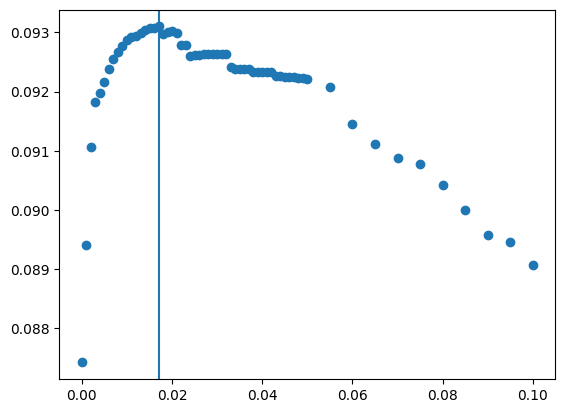

In [117]:
regularisation_identifier = 'R2_gbg'
lambd_opt_cis, R2_gbg_cis, E_R2_gbg_cis, R2_R2_h2_cis, foh2_cis, R2_cis = choose_optimal_L1reg(Y_pred_cis, regularisation_identifier, heritability_df, plot=True)

In [96]:
print('lambd_opt_cis = ', lambd_opt_cis) 
D = D_cis[lambd_opt_cis]
D.to_csv(results_path+'D_cis_lasso_genebygene.csv')

# 3. QOM 1st order

In [ ]:
# if not computed here, load precomputed D
D = pd.read_csv(precomputed_results_path+'D_cis_lasso_genebygene.csv', index_col = 0)

In [100]:
def compute_B_QOM1_for_one_lambda(D, B_prior, lambd):
    '''
    Lasso (L1 norm regularised) regression on selected network links to fit 1st order QOM
    D: (N_indiv, N_genes) direct genetic effects matrix
    B_prior:  (N_genes, N_genes) binary matrix defining the sparsity strustuce of the gene regulatory network matrix B
    lambd: L1 norm regularisation strength
    returns
        B_fit: (N_genes, N_genes) fitted GRN with only the entries specified in B_prior nonzero
    '''

    B_fit = 0.0*B_prior

    XD = X_df_norm@D
    Y_temp = Y_df_norm-XD

    for gene in D.columns:
        clf = Lasso(alpha= lambd, max_iter = 20000, random_state = np.random.randint(1, 100))
        genes_index = B_prior.loc[B_prior.loc[:, gene]>0, gene].index
        if len(genes_index) > 0:
            clf.fit(XD.iloc[individuals_train].loc[:, genes_index], Y_temp.iloc[individuals_train].loc[:, gene])
            B_fit.loc[genes_index, gene] = clf.coef_
            
    B_fit.to_csv(results_path+'B_fit_QOM1_Lasso_genebygene_lambd{}.csv'.format(lambd))
    
    return B_fit


### 3.1 fit QOM1 for different values of L1 regularisor

In [119]:
B_QOM1 = {}
lambd_list_QOM1 = np.append(np.arange(1, 10)/1000, np.arange(2, 10)/100)
for lambd in lambd_list_QOM1:
    print(lambd)
    B_QOM1[lambd] = compute_B_QOM1_for_one_lambda(D, B_prior, lambd)

# or load pre-computed B_QOM1_opt
# B_QOM1_opt = pd.read_csv(precomp_results_path+'B_fit_QOM1_lasso_genebygene.csv', index_col = 0)

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09


In [127]:
Y_pred_QOM1 = {}
for lambd in B_QOM1.keys():
    Y_pred_QOM1[lambd] = X_df_norm@D@(I+B_QOM1[lambd])

### 3.2 pick optimal regularisation

In [129]:
# pick optimal regulariser
regularisation_identifier = 'R2_gbg'
lambd_opt_QOM1, R2_gbg_QOM1, E_R2_gbg_QOM1, R2_R2_h2_QOM1, foh2_QOM1, R2_QOM1 = choose_optimal_L1reg(Y_pred_QOM1, regularisation_identifier, heritability_df)

0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09


In [131]:
print('lambd_opt_QOM1 = ', lambd_opt_QOM1) 
B_QOM1_opt = B_QOM1[lambd_opt_QOM1]
B_QOM1_opt.to_csv(results_path+'B_fit_QOM1_lasso_genebygene.csv')

lambd_opt_QOM1 =  0.002


# 4. QOM 2nd order

In [161]:
def convert_b_into_matrix(omega):
    index = 0
    B_fit_BFGS = 0.0*B_prior
    for i, j in zip(x_nonzero_B, y_nonzero_B):
        B_fit_BFGS.iloc[i, j]= omega[index]
        index+=1
    return B_fit_BFGS

def compute_derivative(i, j, loss, B, XDB, Bloss):
    l = loss.iloc[:, j]
    XD_i = XD.iloc[:, i]
    return 2*(-np.multiply(XD_i, l) - np.multiply(XDB.iloc[:, i],l)- np.multiply(Bloss.iloc[j], XD_i))

alpha = 5E3
x_max = 0.01
def smooth_abs(x, alpha):
    abs_x = np.abs(x)
    abs_x[abs_x<x_max] = 1/alpha*(np.log(1+np.exp(-alpha*x[abs_x<x_max]))+np.log(1+np.exp(alpha*x[abs_x<x_max])))
    return abs_x

def grad_smooth_abs(x, alpha):
    sign_x = np.sign(x)
    abs_x = np.abs(x)
    sign_x[abs_x<x_max] = 1/(1+np.exp(-alpha*x[abs_x<x_max]))-1/(1+np.exp(alpha*x[abs_x<x_max]))
    return sign_x

def objective(b):
    B = convert_b_into_matrix(b)
    loss = YminusXD - XD@B@(I + B)
    # Lasso
    return np.sum(np.diag(loss@loss.T)) + lambd*np.sum(smooth_abs(b, alpha))

def jacobian(b):
    B = convert_b_into_matrix(b)
    XDB = XD@B
    loss = YminusXD - XDB@(I + B)
    Bloss = B@(loss.T)
    deriv = Parallel(n_jobs = n_jobs)(delayed(compute_derivative)(i, j, loss, B, XDB, Bloss) for i, j in index_to_coord_dict.values())
    return np.sum(deriv, axis=1) + lambd*grad_smooth_abs(b, alpha)

def compute_B_QOM2_for_one_lambda(D, B_prior, lambd, precision, max_iter):
    '''
    L-BFGS-B numerical optimisation selected network links to fit 2nd order QOM
    
    D: (N_indiv, N_genes) direct genetic effects matrix
    B_prior: (N_genes, N_genes) binary matrix defining the sparsity strustuce of the gene regulatory network matrix B
    lambd: float, L1 norm regularisation strength
    precision: int, L-BFGS-B parameter. The lower, the more precise. 
    max_iter: int, maximal number of iterations of L-BFGS-B alorithm
    
    returns B_fit: (N_genes, N_genes) fitted GRN with only the entries specified in B_prior nonzero
    '''        
    # BFGS
    max_index = len(B_prior.values.nonzero()[0])

    filename = 'B_fit_QOM2_Lasso_lambd{}_bound={}_prec={}.csv'.format(lambd, bound, precision)

    try: #prior load previous result
        b0 = pd.read_csv(results_path+filename, index_col = 0)
        b0 = b0.values.flatten()[nonzero_B]
    except: # initiate b0=0 if no previous results available
        b0 = 0*nonzero_B
    print('b0', b0)
    
    print('starting optimization')
    result = optimize.fmin_l_bfgs_b(objective, b0, fprime= jacobian, approx_grad=False, iprint = 1, bounds = np.transpose([np.ones(int(B_prior.sum().sum()))*b_min, np.ones(int(B_prior.sum().sum()))*b_max]), factr = precision, maxiter = max_iter, maxls = 20, maxfun=6020000)
    B_fit = pd.DataFrame(convert_b_into_matrix(result[0]), index = B_prior.index, columns = B_prior.columns)
    B_fit.to_csv(results_path+filename)
    print('saved for lambda {}, B_fit to {}'.format(lambd, results_path+filename))
    print('stats: ', 'bound: ', bound, 'precision: ', precision, 'loss:', result[1], 'task:', result[2]['task'], 'num_iter:', result[2]['nit'])

    r_test = pearsonr(Y_df_norm.iloc[individuals_test].values.flatten(), (X_df_norm.iloc[individuals_test]@D@(I+B_fit+B_fit@B_fit)).values.flatten())[0]
    r_train = pearsonr(Y_df_norm.iloc[individuals_train].values.flatten(), (X_df_norm.iloc[individuals_train]@D@(I+B_fit+B_fit@B_fit)).values.flatten())[0]
    print('r_test = {:0.4f}, r_train = {:0.4f}'.format(r_test, r_train))

    return B_fit

### 4.1 fit QOM2 for different values of L1 regularisor

In [210]:
# set L-BFGS-B parameters & prepare variables for fitting
bound = 11.0
precision = 1E6
max_iter = 5
n_jobs = 1

b_min = -bound
b_max = bound

x_nonzero_B = B_prior.values.nonzero()[0]
y_nonzero_B = B_prior.values.nonzero()[1]

coord_to_index_dict = {}
index_to_coord_dict = {}

index = 0
for xx, yy in zip(x_nonzero_B, y_nonzero_B):
    coord_to_index_dict[(xx, yy)] = index
    index_to_coord_dict[index] = (xx, yy)
    index +=1 

indiv = individuals_train
XD = X_df_norm.iloc[indiv]@D
YminusXD = Y_df_norm.iloc[indiv] - XD
nonzero_B  = B_prior.values.flatten().nonzero()[0]

In [ ]:
# if not computed here, load precomputed D
D = pd.read_csv(precomputed_results_path+'D_cis_lasso_genebygene.csv', index_col = 0)

In [185]:
B_QOM2 = {}
lambd_list_QOM2 = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 2. , 3. , 4. , 5. ,
       6. , 7. , 8. ]
for lambd in lambd_list_QOM2:
    print(lambd)
    B_QOM2[lambd] = compute_B_QOM2_for_one_lambda(D, B_prior, lambd, precision, max_iter)

# or load precomputed B_QOM2_opt
# B_QOM2_opt = pd.read_csv(precomp_results_path+'B_fit_QOM2_LBFGS.csv', index_col = 0)

0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
2.0
3.0
4.0
5.0
6.0
7.0
8.0


In [186]:
Y_pred_QOM2 = {}
for lambd in B_QOM2.keys():
    Y_pred_QOM2[lambd] = X_df_norm@D@(I+B_QOM2[lambd]+B_QOM2[lambd]@B_QOM2[lambd])

### 4.2 pick optimal regulariser 

0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
2.0
3.0
4.0
5.0
6.0
7.0
8.0


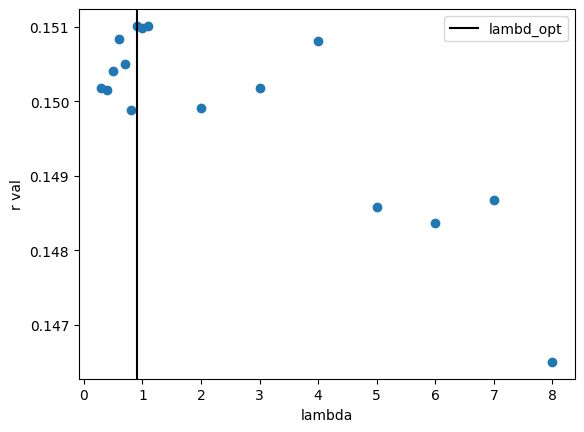

In [187]:
# pick optimal regulariser
regularisation_identifier = 'R2_gbg'
lambd_opt_QOM2, R2_gbg_QOM2, E_R2_gbg_QOM2, R2_R2_h2_QOM2, foh2_QOM2, R2_QOM2 = choose_optimal_L1reg(Y_pred_QOM2, regularisation_identifier, heritability_df)

In [189]:
print('lambd_opt_QOM2 = ', lambd_opt_QOM2) 
B_QOM2_opt = B_QOM2[lambd_opt_QOM2]
B_QOM2_opt.to_csv(results_path+'B_fit_QOM2_LBFGS.csv')

lambd_opt_QOM2 =  0.9


# 5. QOM 3rd order

In [216]:
def convert_b_into_matrix(omega):
    index = 0
    B_fit_BFGS = 0.0*B_prior
    for i, j in zip(x_nonzero_B, y_nonzero_B):
        B_fit_BFGS.iloc[i, j]= omega[index]
        index+=1
    return B_fit_BFGS

def compute_derivative(i, j, loss, B, XDB, Bloss, Bloss_T):
    XD_i = XD.iloc[:, i]
    l = loss.iloc[:, j]
    Bloss_j = Bloss.iloc[j]
    XDB_i = XDB.iloc[:, i]
#     second_order = np.multiply(XD_i, l) + np.multiply(XDB.iloc[:, i],l) + np.multiply(Bloss_j, XD_i)
#     third_order_corr = np.multiply(XD_i, loss@B.T@B.iloc[j]) + np.multiply(l, XDB@B.iloc[:, i]) + np.multiply(Bloss_j, XDB.iloc[:, i])
#     return -2*np.sum(second_order + third_order_corr)
    return -2*np.sum(np.multiply(XD_i, l+(Bloss_T)@B.iloc[j]) + np.multiply(XDB_i+XDB@(B.iloc[:, i]),l) + np.multiply(Bloss_j, XD_i+XDB_i))

alpha = 5E3
x_max = 0.01
def smooth_abs(x, alpha):
    abs_x = np.abs(x)
    abs_x[abs_x<x_max] = 1/alpha*(np.log(1+np.exp(-alpha*x[abs_x<x_max]))+np.log(1+np.exp(alpha*x[abs_x<x_max])))
    return abs_x

def grad_smooth_abs(x, alpha):
    sign_x = np.sign(x)
    abs_x = np.abs(x)
    sign_x[abs_x<x_max] = 1/(1+np.exp(-alpha*x[abs_x<x_max]))-1/(1+np.exp(alpha*x[abs_x<x_max]))
    return sign_x

def objective(b):
    B = convert_b_into_matrix(b)
    loss = YminusXD - XD@B@(I + B + B@B)
    #LASSO
    return np.sum(np.diag(loss@loss.T)) + lambd*np.sum(smooth_abs(b, alpha))
if n_jobs>1:
    def jacobian(b):
        B = convert_b_into_matrix(b)
        XDB = XD@B
        loss = YminusXD - XDB@(I + B + B@B)
        Bloss = B@(loss.T)
        Bloss_T = Bloss.T
        deriv = Parallel(n_jobs = n_jobs)(delayed(compute_derivative)(i, j, loss, B, XDB, Bloss, Bloss_T) for i, j in index_to_coord_dict.values())
        return deriv+lambd*grad_smooth_abs(b, alpha)
else:
    def jacobian(b):
        B = convert_b_into_matrix(b)
        XDB = XD@B
        loss = YminusXD - XDB@(I + B + B@B)
        Bloss = B@(loss.T)
        Bloss_T = Bloss.T
        deriv = [compute_derivative(i, j, loss, B, XDB, Bloss, Bloss_T) for i, j in index_to_coord_dict.values()]
        return deriv+lambd*grad_smooth_abs(b, alpha)


def compute_B_QOM3_for_one_lambda(D, B_prior, lambd, precision, max_iter):
    '''
    L-BFGS-B numerical optimisation selected network links to fit 3rd order QOM
    
    D: (N_indiv, N_genes) direct genetic effects matrix
    B_prior: (N_genes, N_genes) binary matrix defining the sparsity strustuce of the gene regulatory network matrix B
    lambd: float, L1 norm regularisation strength
    precision: int, L-BFGS-B parameter. The lower, the more precise. 
    max_iter: int, maximal number of iterations of L-BFGS-B alorithm
    
    returns B_fit: (N_genes, N_genes) fitted GRN with only the entries specified in B_prior nonzero
    '''        
    # BFGS
    max_index = len(B_prior.values.nonzero()[0])

    filename = 'B_fit_QOM3_Lasso_lambd{}_bound={}_prec={}.csv'.format(lambd, bound, precision)

    try: #prior load previous result
        b0 = pd.read_csv(results_path+filename, index_col = 0)
        b0 = b0.values.flatten()[nonzero_B]
    except: # initiate b0=0 if no previous results available
        b0 = 0*nonzero_B
    print('b0', b0)
    
    print('starting optimization')
    result = optimize.fmin_l_bfgs_b(objective, b0, fprime= jacobian, approx_grad=False, iprint = 1, bounds = np.transpose([np.ones(int(B_prior.sum().sum()))*b_min, np.ones(int(B_prior.sum().sum()))*b_max]), factr = precision, maxiter = max_iter, maxls = 20, maxfun=6020000)
    B_fit = pd.DataFrame(convert_b_into_matrix(result[0]), index = B_prior.index, columns = B_prior.columns)
    B_fit.to_csv(results_path+filename)
    print('saved for lambda {}, B_fit to {}'.format(lambd, results_path+filename))
    print('stats: ', 'bound: ', bound, 'precision: ', precision, 'loss:', result[1], 'task:', result[2]['task'], 'num_iter:', result[2]['nit'])

    Y_pred = X_df_norm@D@(I+B_fit+B_fit@B_fit+B_fit@B_fit@B_fit)
    r_test = pearsonr(Y_df_norm.iloc[individuals_test].values.flatten(), Y_pred.iloc[individuals_test].values.flatten())[0]
    r_train = pearsonr(Y_df_norm.iloc[individuals_train].values.flatten(),Y_pred.iloc[individuals_train].values.flatten())[0]
    print('r_test = {:0.4f}, r_train = {:0.4f}'.format(r_test, r_train))

    return B_fit

### 5.1 fit QOM3 for different values of L1 regularisor

In [214]:
# set L-BFGS-B parameters & prepare variables for fitting
bound = 11.0
precision = 1E6
max_iter = 5
n_jobs = 1

b_min = -bound
b_max = bound

x_nonzero_B = B_prior.values.nonzero()[0]
y_nonzero_B = B_prior.values.nonzero()[1]

coord_to_index_dict = {}
index_to_coord_dict = {}

index = 0
for xx, yy in zip(x_nonzero_B, y_nonzero_B):
    coord_to_index_dict[(xx, yy)] = index
    index_to_coord_dict[index] = (xx, yy)
    index +=1 

indiv = individuals_train
XD = X_df_norm.iloc[indiv]@D
YminusXD = Y_df_norm.iloc[indiv] - XD
nonzero_B  = B_prior.values.flatten().nonzero()[0]

In [ ]:
# if not computed here, load precomputed D
D = pd.read_csv(precomputed_results_path+'D_cis_lasso_genebygene.csv', index_col = 0)

In [226]:
B_QOM3 = {}
lambd_list_QOM3 = [ 0.8,  1. ,  1.1,  1.3,  1.5,  1.7,  1.9,  2. ,  3. ,  4. ,  5. ,
        6. ,  7. ,  8. ,  9. , 10. ]

for lambd in lambd_list_QOM3:
    print(lambd)
    B_QOM3[lambd] = compute_B_QOM3_for_one_lambda(D, B_prior, lambd, precision, max_iter)

# or load precomputed B_QOM3_opt
# B_QOM3_opt = pd.read_csv(precomp_results_path+'B_fit_QOM3_LBFGS.csv', index_col = 0)

0.8
1.0
1.1
1.3
1.5
1.7
1.9
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


In [235]:
Y_pred_QOM3 = {}
for lambd in B_QOM3.keys():
    Y_pred_QOM3[lambd] = X_df_norm@D@(I+B_QOM3[lambd]+B_QOM3[lambd]@B_QOM3[lambd]+B_QOM3[lambd]@B_QOM3[lambd]@B_QOM3[lambd])

### 5.2 pick optimal regulariser 

0.8
1.0
1.1
1.3
1.5
1.7
1.9
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0


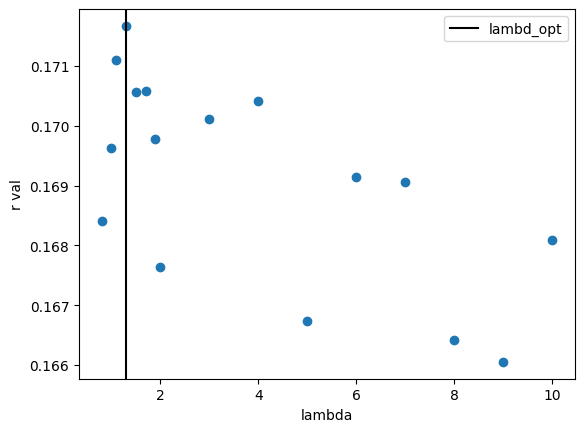

In [236]:
# pick optimal regulariser
regularisation_identifier = 'R2_gbg'
lambd_opt_QOM3, R2_gbg_QOM3, E_R2_gbg_QOM3, R2_R2_h2_QOM3, foh2_QOM3, R2_QOM3 = choose_optimal_L1reg(Y_pred_QOM3, regularisation_identifier, heritability_df)

In [237]:
print('lambd_opt_QOM3 = ', lambd_opt_QOM3) 
B_QOM3_opt = B_QOM3[lambd_opt_QOM3]
B_QOM3_opt.to_csv(results_path+'B_fit_QOM3_LBFGS.csv')

lambd_opt_QOM3 =  1.3


# 6. QOM bound

In [241]:
# define QOM prior given the fitted direct effects matrix D

for n in range(10):
    A = 0.0*B_prior
    x = B_prior.values.nonzero()[0]
    for x, y in zip(B_prior.values.nonzero()[0], B_prior.values.nonzero()[1]):
        A.iloc[x, y] = 5E-3*np.random.rand()

# QOM bound prior could be defined using D_prior, or D fitted (conservative estimate)
QOM_bound_prior = np.abs(np.sign(D_prior@np.linalg.inv(I-A)))
# QOM_bound_prior = np.abs(np.sign(D@np.linalg.inv(I-A)))
QOM_bound_prior.columns = B_prior.columns
print('defined QOM_bound_prior')

defined QOM_bound_prior


In [248]:
def compute_G_QOM_bound_for_one_lambda(QOM_bound_prior, lambd): 
    '''
    QOM bound given QOM_bound_prior, estimated by Lasso (L1 norm regularised) regression
    QOM_bound_prior: (N_markers, N_genes) binary matrix defining the sparsity structure of QOM bound model
    lambd: L1 norm regularisation strength
    returns
        G_fit: (N_markers, N_genes) matrix of genetic effects
    '''
    
    G_fit = 0*QOM_bound_prior
    for gene in QOM_bound_prior.columns:
        print(gene)
        clf = Lasso(alpha=lambd, max_iter = 100000)
        cis_SNPs_index = QOM_bound_prior.loc[QOM_bound_prior.loc[:, gene]>0, gene].index
        if len(cis_SNPs_index) > 0:
            clf.fit(X_df_full.iloc[individuals_train].loc[:, cis_SNPs_index], Y_df_norm.iloc[individuals_train].loc[:, gene])
            G_fit.loc[cis_SNPs_index, gene] = clf.coef_            
    G_fit.to_csv(results_path+'G_QOM_bound_Lasso_lambd{}.csv'.format(lambd))
    print('COMPLETED for lambda {}'.format(lambd))
    return G_fit

### 6.1 fit QOM bound for different values of L1 regularisor

In [284]:
G_QOM_bound = {}
lambd_list_QOM_bound = [0.016, 0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032,
       0.034, 0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048]

for lambd in lambd_list_QOM_bound:
    print(lambd)
    G_QOM_bound[lambd] = compute_G_QOM_bound_for_one_lambda(D, QOM_bound_prior, lambd)

# or load precomputed G_QOM_bound_opt
# G_QOM_bound_opt = pd.read_csv(precomp_results_path+'G_fit_QOM_bound_Lasso_genebygene.csv', index_col = 0)

0.016
0.018
0.02
0.022
0.024
0.026
0.028
0.03
0.032
0.034
0.036
0.038
0.04
0.042
0.044
0.046
0.048


In [278]:
Y_pred_QOM_bound = {}
for lambd in G_QOM_bound.keys():
    Y_pred_QOM_bound[lambd] = X_df_norm@G_QOM_bound[lambd]

### 6.2 pick optimal regulariser 

0.016
0.018
0.02
0.022
0.024
0.026
0.028
0.03
0.032
0.034
0.036
0.038
0.04
0.042
0.044
0.046
0.048


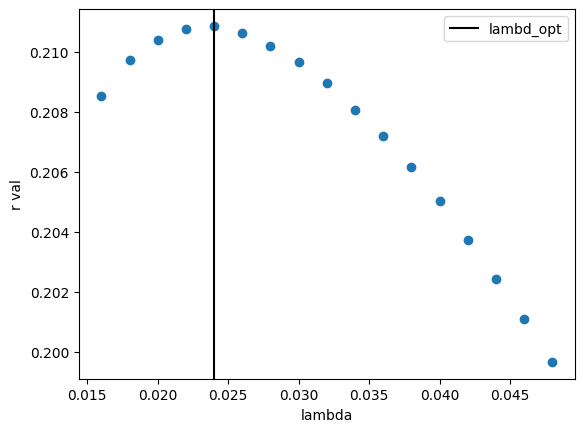

In [279]:
# pick optimal regulariser
regularisation_identifier = 'R2_gbg'
lambd_opt_QOM_bound, R2_gbg_QOM_bound, E_R2_gbg_QOM_bound, R2_R2_h2_QOM_bound, foh2_QOM_bound, R2_QOM_bound = choose_optimal_L1reg(Y_pred_QOM_bound, regularisation_identifier, heritability_df)

In [285]:
print('lambd_opt_QOM_bound = ', lambd_opt_QOM_bound) 
G_QOM_bound_opt = G_QOM_bound[lambd_opt_QOM_bound]
G_QOM_bound_opt.to_csv(results_path+'G_fit_QOM_bound_Lasso_genebygene.csv')

lambd_opt_QOM_bound =  0.024


# 7. PRS

In [313]:
def compute_G_PRS_for_one_lambda(lambd):  
    '''
    polygenic risk score (PRS) fitted using all markers by Lasso (L1 norm regularised) regression
    lambd: L1 norm regularisation strength
    returns
        G_fit: (N_markers, N_genes) matrix of genetic effects
    '''
    G_fit = pd.DataFrame(np.zeros([X_df_full.shape[1], Y_df_norm.shape[1]]), index = X_df_full.columns, columns = Y_df_norm.columns)   
    for gene in Y_df_norm.columns:
        print(gene)
        clf = Lasso(alpha = lambd, max_iter = 200000)
        clf.fit(X_df_full.iloc[individuals_train], Y_df_norm.iloc[individuals_train].loc[:, gene])
        G_fit[gene] = clf.coef_
        
    G_fit.to_csv(results_path+'G_PRS_Lasso_genebygene_lambd{}.csv'.format(lambd))
    print('COMPLETED for lambd {}'.format(lambd))
    return G_fit

### 7.1 fit PRS for different values of L1 regularisor

In [314]:
G_PRS = {}
lambd_list_PRS = [0.01 , 0.011, 0.015, 0.016, 0.02 ,
       0.021, 0.025, 0.026, 0.03 , 0.031, 0.035, 0.036, 0.04 , 0.041,
       0.045, 0.046, 0.05 , 0.051, 0.055, 0.056, 0.06 , 0.061, 0.065,
       0.066, 0.07]

for lambd in lambd_list_PRS:
    print(lambd)
    G_PRS[lambd] = compute_G_PRS_for_one_lambda(lambd)

# or load precomputed G_PRS_opt
# G_PRS_opt = pd.read_csv(precomp_results_path+'G_fit_PRS_Lasso_genebygene.csv', index_col = 0)

0.01
0.011
0.015
0.016
0.02
0.021
0.025
0.026
0.03
0.031
0.035
0.036
0.04
0.041
0.045
0.046
0.05
0.051
0.055
0.056
0.06
0.061
0.065
0.066
0.07


In [315]:
Y_pred_PRS = {}
for lambd in G_PRS.keys():
    Y_pred_PRS[lambd] = X_df_full@G_PRS[lambd]

### 7.2 pick optimal regulariser 

0.01
0.011
0.015
0.016
0.02
0.021
0.025
0.026
0.03
0.031
0.035
0.036
0.04
0.041
0.045
0.046
0.05
0.051
0.055
0.056
0.06
0.061
0.065
0.066
0.07


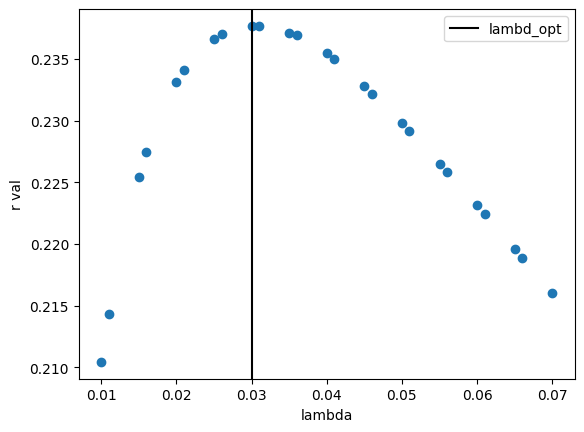

In [316]:
# pick optimal regulariser
regularisation_identifier = 'R2_gbg'
lambd_opt_PRS, R2_gbg_PRS, E_R2_gbg_PRS, R2_R2_h2_PRS, foh2_PRS, R2_PRS = choose_optimal_L1reg(Y_pred_PRS, regularisation_identifier, heritability_df)

In [317]:
print('lambd_opt_PRS = ', lambd_opt_PRS) 
G_PRS_opt = G_PRS[lambd_opt_PRS]
G_PRS_opt.to_csv(results_path+'G_fit_PRS_Lasso_genebygene.csv')

lambd_opt_PRS =  0.03


# 8. Shuffle GRN matrix

In [319]:
def shuffle_B(B_prior, keep_topology, return_genes_order = False):
    '''
    shuffles GRN matrix topology B_prior conserving the number of edges and other attributed defined by keep_topology
    B_prior: (N_genes, N_genes) binary matrix defining the sparsity strustuce of the gene regulatory network matrix B
    keep_topology: int; constraint on conserving topological properties of original B_prior
        0: conserve only the number of links
        1: conserve network topology: permute rows and column labels synchronously
        2: conserve in-degree: permute column labels only
        3: conserve out-degree: permute index labels only
    return_genes_order: bool; if True returns label permutation key
    returns: 
        B_prior: (N_genes, N_genes) shuffled GRN topology
    '''

    if keep_topology==0:
        B_prior_new = B_prior.values.flatten()
        np.random.shuffle(B_prior_new)
        B_prior = pd.DataFrame(B_prior_new.reshape(B_prior.shape), columns = B_prior.columns, index = B_prior.index)
    
    elif keep_topology==1:
        genes_order = np.array(B_prior.columns)
        np.random.shuffle(genes_order)
        B_prior.columns = genes_order
        B_prior.index = genes_order
        B_prior = B_prior.sort_index(axis=0)
        B_prior = B_prior.sort_index(axis=1)
    
    elif keep_topology==2: #shuffle only columns (targets)
        selfloops = True
        while selfloops:
            genes_order = np.array(B_prior.columns)
            np.random.shuffle(genes_order)
            B_prior.columns = genes_order
            B_prior = B_prior.sort_index(axis=1)
            selfloops = bool(np.diag(B_prior).sum())
    
    elif keep_topology==3: #shuffle only rows (regulators)
        selfloops = True
        while selfloops:
            genes_order = np.array(B_prior.columns)
            np.random.shuffle(genes_order)
            B_prior.index = genes_order
            B_prior = B_prior.sort_index(axis=0)
            selfloops = bool(np.diag(B_prior).sum())
    
    if return_genes_order:
        return B_prior, genes_order
    else:
        return B_prior

In [321]:
B_prior_new = shuffle_B(B_prior, keep_topology=1)